In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [2]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
h = 1e-3  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 40

# Set the diffusion coefficient
sigma = 1.09

In [ ]:
print('lag time: ', lag_time)

In [3]:
# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

100%|██████████| 1600/1600 [00:21<00:00, 73.14it/s]


In [4]:
## Save the data to local folder
# Create a folder to store the data (if it doesn't exist)
folder_path = "data"
os.makedirs(folder_path, exist_ok=True)

# Save the data_matrix to a file
file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
np.save(file_path, data_matrix)

In [5]:
## load the data from local folder
import os
# Load the data_matrix from the file
folder_path = "data"
file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
data_matrix = np.load(file_path)
data_matrix.shape

(1600, 11, 2)

In [6]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[15], n_psi_train=12).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=4,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Shape of data_X: (1600, 10, 2)
Shape of data_Y: (1600, 10, 2)
Shape of X: (16000, 2)
Shape of Y: (16000, 2)
(11200, 2)
Epoch: 1 	Training Loss: 0.753493 val loss: 0.733635
saving, val loss enhanced: 0.733635490098386 10000
Epoch: 2 	Training Loss: 0.669004 val loss: 0.650719
saving, val loss enhanced: 0.650718546510444 0.733635490098386
Epoch: 3 	Training Loss: 0.602932 val loss: 0.590440
saving, val loss enhanced: 0.5904401926756254 0.650718546510444
Epoch: 4 	Training Loss: 0.553604 val loss: 0.545754
saving, val loss enhanced: 0.5457542414775074 0.5904401926756254
Epoch: 5 	Training Loss: 0.515929 val loss: 0.514215
saving, val loss enhanced: 0.5142151050641027 0.5457542414775074
Epoch: 6 	Training Loss: 0.485370 val loss: 0.482744
saving, val loss enhanced: 0.482744061023383 0.5142151050641027
Epoch: 7 	Training Loss: 0.458566 val loss: 0.457170
saving, val loss enhanced: 0.45717025907227155 0.482744061023383
Epoch: 8 	Training Loss: 0.435653 val loss: 0.434881
saving, val loss enh

Computing dPsi_X: 100%|██████████| 167985/167985 [00:42<00:00, 3932.21iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Outer Epoch 1/4


Computing dPsi_X: 100%|██████████| 167985/167985 [00:53<00:00, 3111.78iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 36.102513 val loss: 36.223418
saving, val loss enhanced: 36.22341849001537 1000000000000000.0
Epoch: 2 	Training Loss: 35.732421 val loss: 36.003868
saving, val loss enhanced: 36.003868085904315 36.22341849001537
Epoch: 3 	Training Loss: 35.364778 val loss: 35.787156
saving, val loss enhanced: 35.78715593001099 36.003868085904315
Epoch: 4 	Training Loss: 35.000012 val loss: 35.573076
saving, val loss enhanced: 35.57307635453725 35.78715593001099
Epoch: 5 	Training Loss: 34.638534 val loss: 35.361510
saving, val loss enhanced: 35.36150988796941 35.57307635453725
Epoch: 6 	Training Loss: 34.280456 val loss: 35.152370
saving, val loss enhanced: 35.15236971705694 35.36150988796941
Epoch: 7 	Training Loss: 33.925786 val loss: 34.945581
saving, val loss enhanced: 34.945580881961504 35.15236971705694
Epoch: 8 	Training Loss: 33.574494 va

Computing dPsi_X: 100%|██████████| 167985/167985 [00:49<00:00, 3381.22iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 11.318483 val loss: 21.133170
saving, val loss enhanced: 21.133169895761476 22.320683520942207
Epoch: 2 	Training Loss: 11.291351 val loss: 21.091480
saving, val loss enhanced: 21.091480223054127 21.133169895761476
Epoch: 3 	Training Loss: 11.262608 val loss: 21.049674
saving, val loss enhanced: 21.049674064847707 21.091480223054127
Epoch: 4 	Training Loss: 11.233772 val loss: 21.007804
saving, val loss enhanced: 21.0078036647372 21.049674064847707
Epoch: 5 	Training Loss: 11.204851 val loss: 20.965854
saving, val loss enhanced: 20.96585365873994 21.0078036647372
Epoch: 6 	Training Loss: 11.175838 val loss: 20.923810
saving, val loss enhanced: 20.923810350913595 20.96585365873994
Epoch: 7 	Training Loss: 11.146728 val loss: 20.881662
saving, val loss enhanced: 20.881661966809485 20.923810350913595
Epoch: 8 	Training Loss: 11.11751

Computing dPsi_X: 100%|██████████| 167985/167985 [00:47<00:00, 3529.41iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 13.355091 val loss: 32.758393
Epoch: 2 	Training Loss: 12.933819 val loss: 32.267445
Epoch: 3 	Training Loss: 12.574619 val loss: 31.846256
Epoch: 4 	Training Loss: 12.262570 val loss: 31.469992
Epoch: 5 	Training Loss: 11.982578 val loss: 31.125971
Epoch: 6 	Training Loss: 11.726418 val loss: 30.806699
Epoch: 7 	Training Loss: 11.488967 val loss: 30.507261
Epoch: 8 	Training Loss: 11.266755 val loss: 30.224208
Epoch: 9 	Training Loss: 11.057291 val loss: 29.955000
Epoch: 10 	Training Loss: 10.858709 val loss: 29.697700
Epoch: 11 	Training Loss: 10.669568 val loss: 29.450788
Epoch: 12 	Training Loss: 10.488727 val loss: 29.213045
Epoch: 13 	Training Loss: 10.315262 val loss: 28.983478
Epoch: 14 	Training Loss: 10.148414 val loss: 28.761259
Epoch: 15 	Training Loss: 9.987548 val loss: 28.545695
Epoch: 16 	Training Loss: 9.832132 va

Computing dPsi_X: 100%|██████████| 167985/167985 [00:51<00:00, 3271.53iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 19.876397 val loss: 38.956750
Epoch: 2 	Training Loss: 19.255311 val loss: 38.563150
Epoch: 3 	Training Loss: 18.741941 val loss: 38.234980
Epoch: 4 	Training Loss: 18.306121 val loss: 37.947354
Epoch: 5 	Training Loss: 17.921210 val loss: 37.687975
Epoch: 6 	Training Loss: 17.573124 val loss: 37.449756
Epoch: 7 	Training Loss: 17.253317 val loss: 37.228149
Epoch: 8 	Training Loss: 16.956115 val loss: 37.020023
Epoch: 9 	Training Loss: 16.677522 val loss: 36.823111
Epoch: 10 	Training Loss: 16.414594 val loss: 36.635708
Epoch: 11 	Training Loss: 16.165089 val loss: 36.456497
Epoch: 12 	Training Loss: 15.927255 val loss: 36.284433
Epoch: 13 	Training Loss: 15.699693 val loss: 36.118674
Epoch: 14 	Training Loss: 15.481264 val loss: 35.958526
Epoch: 15 	Training Loss: 15.271029 val loss: 35.803416
Epoch: 16 	Training Loss: 15.068203 

(15,)
[9.99997189e-01 9.92702518e-01 8.84991998e-01 5.56397259e-01
 5.38636214e-01 3.49581342e-01 2.73021102e-01 2.24160058e-01
 1.18214762e-01 9.95274733e-03 5.35288725e-03 1.95238488e-04
 3.76792626e-05 8.87424539e-06 1.98486401e-06]


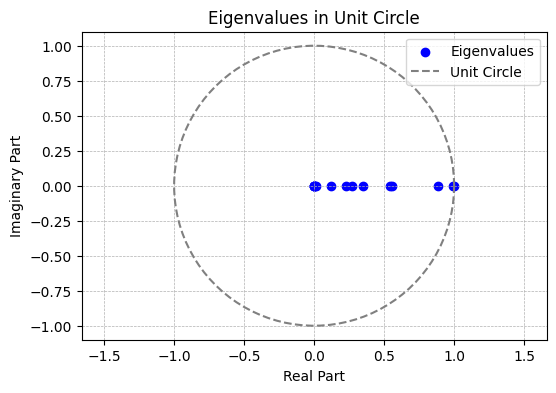

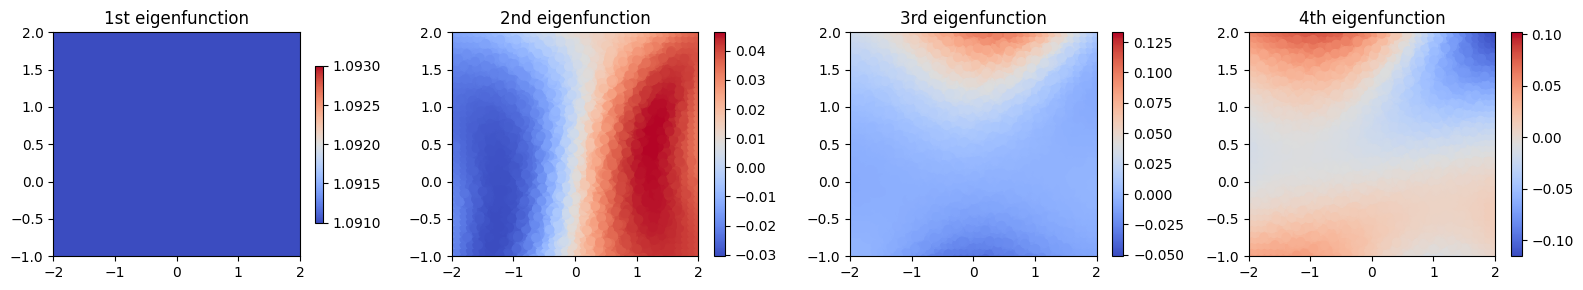

In [7]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])

plt.tight_layout()
plt.show()


In [8]:
# inner epoch = 100
# training step for fnn = 200